<a href="https://colab.research.google.com/github/adityaharshsingh7/ml/blob/main/machinelearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")


In [ ]:
# Display the first few rows of the dataset
print(data.head())

  holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0     NaN  288.28      0.0      0.0          40       Clouds   
1     NaN  289.36      0.0      0.0          75       Clouds   
2     NaN  289.58      0.0      0.0          90       Clouds   
3     NaN  290.13      0.0      0.0          90       Clouds   
4     NaN  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918  


In [ ]:
# Summary statistics
print(data.describe())

               temp       rain_1h       snow_1h    clouds_all  traffic_volume
count  48204.000000  48204.000000  48204.000000  48204.000000    48204.000000
mean     281.205870      0.334264      0.000222     49.362231     3259.818355
std       13.338232     44.789133      0.008168     39.015750     1986.860670
min        0.000000      0.000000      0.000000      0.000000        0.000000
25%      272.160000      0.000000      0.000000      1.000000     1193.000000
50%      282.450000      0.000000      0.000000     64.000000     3380.000000
75%      291.806000      0.000000      0.000000     90.000000     4933.000000
max      310.070000   9831.300000      0.510000    100.000000     7280.000000


In [ ]:
# Check for missing values
print(data.isnull().sum())

holiday                48143
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
date_time                  0
traffic_volume             0
dtype: int64


In [ ]:
# Convert 'date_time' column to datetime format
data['date_time'] = pd.to_datetime(data['date_time'])

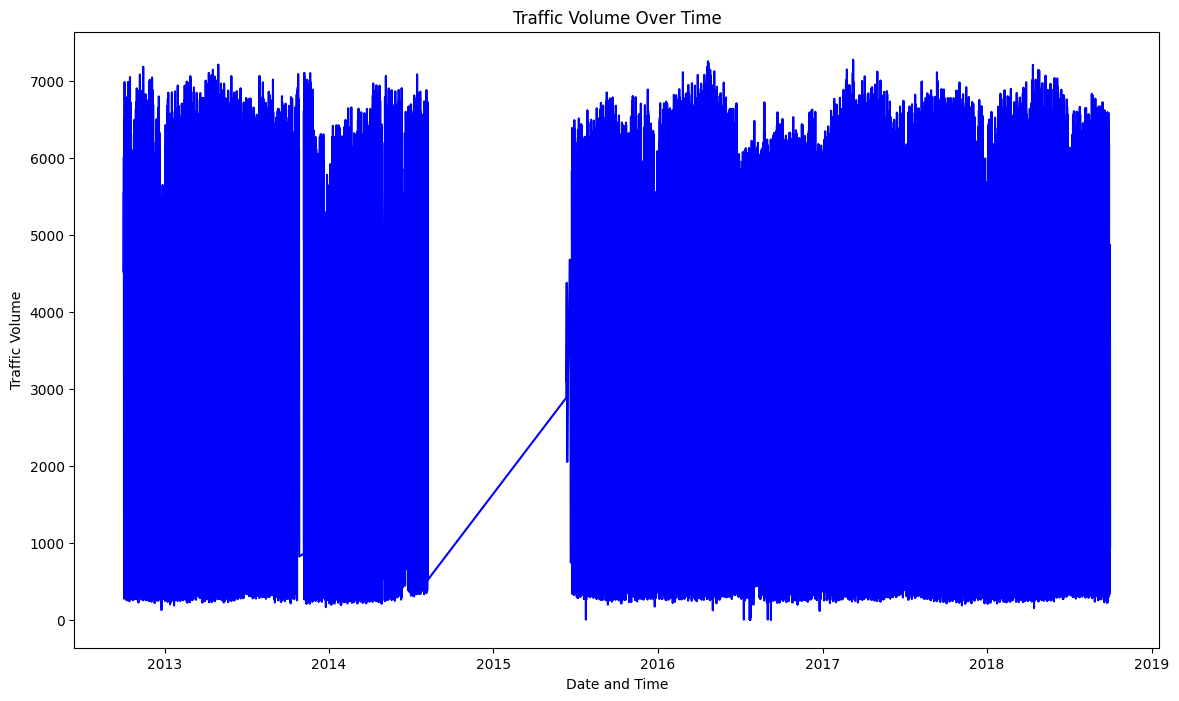

In [ ]:
# Plot traffic volume over time
plt.figure(figsize=(14, 8))
plt.plot(data['date_time'], data['traffic_volume'], color='blue')
plt.title('Traffic Volume Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Traffic Volume')
plt.show()


# Convert categorical variables to numerical using one-hot encoding
data = pd.get_dummies(data, columns=['holiday', 'weather_main'], drop_first=True)

# Drop irrelevant columns
data = data.drop(['weather_description', 'date_time'], axis=1)

In [ ]:
# Separate features and target
X = data.drop('traffic_volume', axis=1)
y = data['traffic_volume']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Machine': SVR()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R-squared': r2}

# Print results
for name, result in results.items():
    print(f"Model: {name}")
    print(f"MSE: {result['MSE']}")
    print(f"R-squared: {result['R-squared']}")
    print()

In [ ]:
# Feature selection
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_selected, y_train)
best_rf_model = grid_search.best_estimator_

# Ensemble methods
from sklearn.ensemble import VotingRegressor
ensemble_model = VotingRegressor(estimators=[
    ('lr', LinearRegression()),
    ('rf', best_rf_model),
    ('gb', GradientBoostingRegressor(random_state=42)),
    ('svr', SVR())
])
ensemble_model.fit(X_train_selected, y_train)

# Evaluate the models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': best_rf_model,
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Machine': SVR(),
    'Ensemble': ensemble_model
}

results = {}
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R-squared': r2}

# Print the results
for name, result in results.items():
    print(f"Model: {name}")
    print(f"MSE: {result['MSE']}")
    print(f"R-squared: {result['R-squared']}")
    print()

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Model: Linear Regression
MSE: 3788376.255825109
R-squared: 0.041769757656970996

Model: Random Forest
MSE: 3552251.481358159
R-squared: 0.10149505540498427

Model: Gradient Boosting
MSE: 3633614.4022164107
R-squared: 0.08091515359299839

Model: Support Vector Machine
MSE: 3809449.026816779
R-squared: 0.036439620128224104

Model: Ensemble
MSE: 3630238.096834499
R-squared: 0.08176915480772962



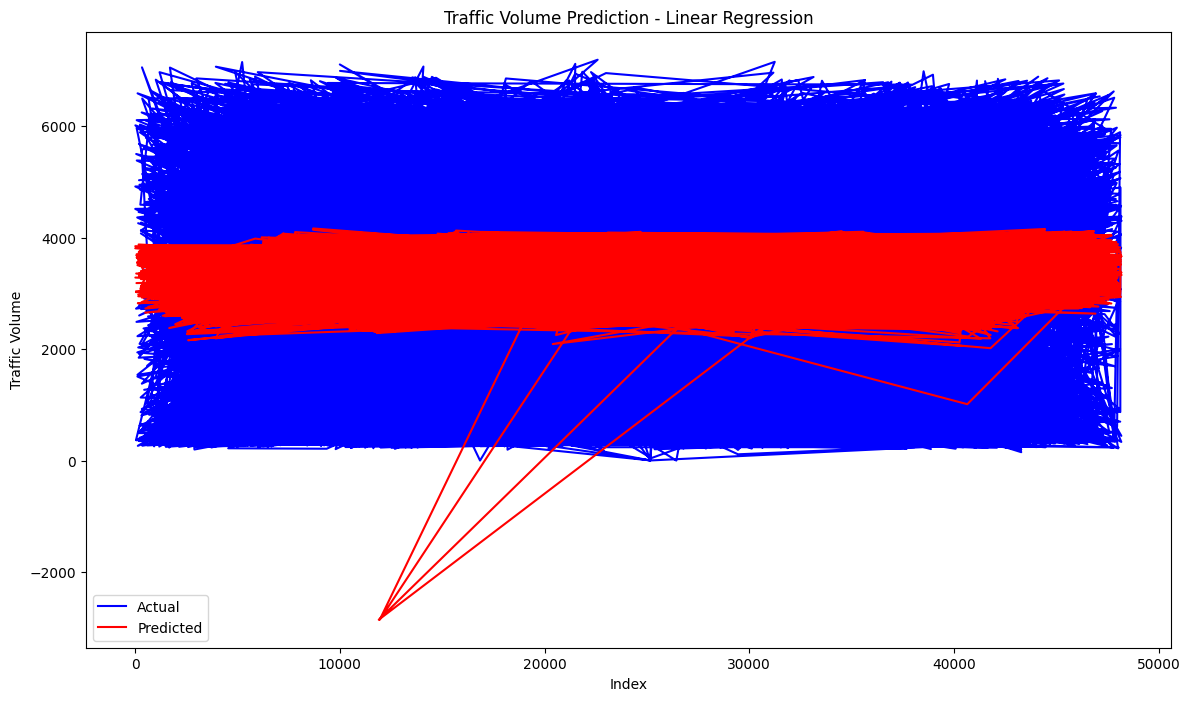

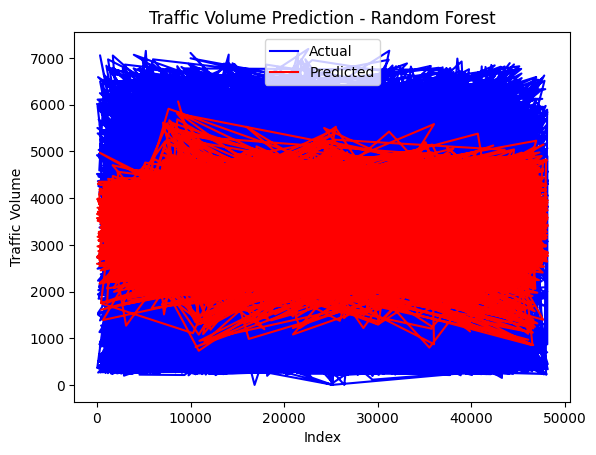

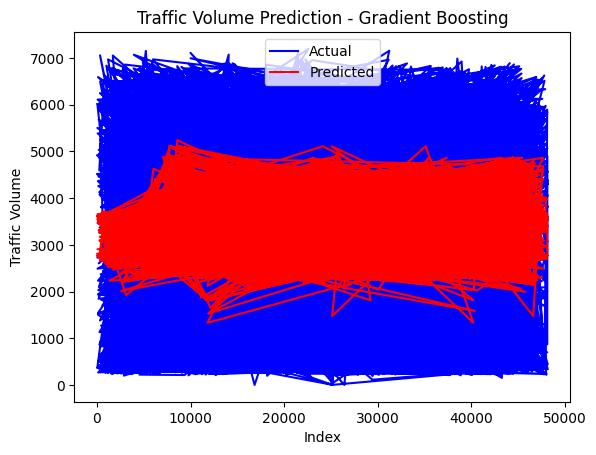

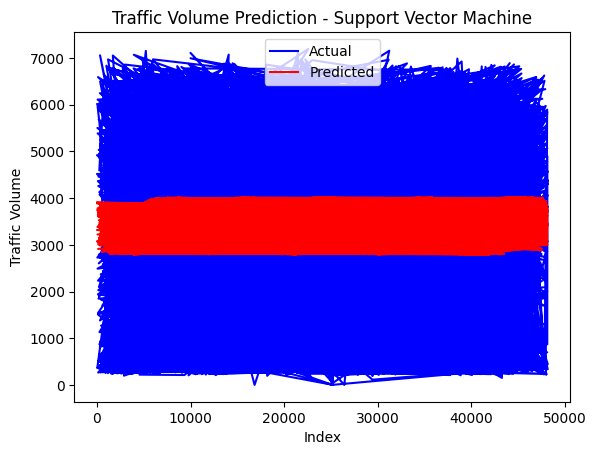

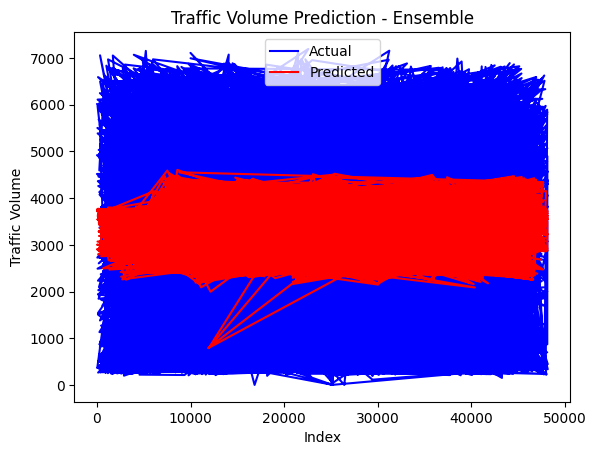

In [ ]:
# Visualize the results
plt.figure(figsize=(14, 8))
for name, model in models.items():
    y_pred = model.predict(X_test_selected)
    plt.plot(y_test.index, y_test, label='Actual', color='blue')
    plt.plot(y_test.index, y_pred, label='Predicted', color='red')
    plt.title(f"Traffic Volume Prediction - {name}")
    plt.xlabel('Index')
    plt.ylabel('Traffic Volume')
    plt.legend()
    plt.show()